### Read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

%run plot.py

/home/prody/anaconda3/envs/unipd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import numpy as np
str1 = []
for N in [20,50,100,150,200,250,300,400,500]:
    str0 = f'ts_L60_Z12_A1000_DX50_bias5_N{N}.dat'
    str1.append(str0)

xdata = []
ydata = []    
for i in str1:
    fnamex='DATA_XGBOOST/x_'+i
    fnamey='DATA_XGBOOST/y_'+i
    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    y = np.loadtxt(fnamey, dtype=int)
    xdata.append(x)
    ydata.append(y)

In [3]:
#print(xdata[0])
#for i in range(8):
#    print(len(xdata[i]),len(ydata[i]))

x_ = xdata
y_ = ydata

print(len(x_[0]))
print(len(x_[1]))

20
50


In [5]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

n_class = 3
Nlist = [20,50,100,150,200,250,300,400,500]
train_acc = []
val_acc = []
std_ = []
for idx, x in enumerate(x_):
    df = get_df(x)
    N = Nlist[idx]
    y = y_[idx]
    #extract features
    x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=0) #number of cores
    x_features
    #remove columns with NaN or inf
    x_features.replace([np.inf, -np.inf], np.nan)
    x_features = x_features.dropna(axis='columns')
    #split data into training and validation

    perc_train=0.8
    N_train = int(perc_train*N)
    x_train = x_features[:N_train]
    y_train = y[:N_train]
    x_val = x_features[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)
    print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

    #rescale: in each feature, remove average and divide by std
    if True:
        average = np.mean(x_train,axis=0)
        x_train -= average
        x_val -= average

        std = np.std(x_train,axis=0, dtype=np.float64)
        std_.append(std)
        x_train /= std
        x_val /= std
    # reproducibility
    np.random.seed(12345)

    #define parameters for xgboost
    params = {'max_depth':6,'min_child_weight':1,\
              'learning_rate':0.3,'use_label_encoder':False}

    #build model with given params
    model = XGBClassifier(**params)

    #fit
    
    print(x_train.values,y_train)
    model.fit(x_train.values,y_train)
    
    from sklearn.metrics import accuracy_score

    #predict labels on training set
    y_pred_train = model.predict(x_train)
    #predict labels on validation set
    y_pred_val = model.predict(x_val)

    y_pred_val_soft = model.predict_proba(x_val)



    #compute accuracies
    acc_train = accuracy_score(y_train,y_pred_train) 
    acc_val = accuracy_score(y_val,y_pred_val)
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    #print accuracies
    print('Training accuracy:',acc_train)
    print('Validation accuracy:',acc_val)
    import seaborn as sns
    from sklearn import metrics

    LABELS = ["absent","positive","negative"]
    cmap="GnBu"

    def show_confusion_matrix(validations, predictions, label="Model"):

        matrix = metrics.confusion_matrix(validations, predictions)
        plt.figure(figsize=(6, 5))
        sns.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
        plt.title(label+': Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    y_pred_val = model.predict(x_val)
    show_confusion_matrix(y_val, y_pred_val)
    

Feature Extraction:   0%|                                                                                                                                                           | 0/20 [00:00<?, ?it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 22

TypeError: acf() got an unexpected keyword argument 'unbiased'

In [221]:
std_[0]

value__variance_larger_than_standard_deviation        0.000000
value__has_duplicate_max                              0.000000
value__has_duplicate_min                              0.000000
value__has_duplicate                                  0.000000
value__sum_values                                 89077.347910
                                                      ...     
value__permutation_entropy__dimension_4__tau_1        0.079703
value__permutation_entropy__dimension_5__tau_1        0.137279
value__permutation_entropy__dimension_6__tau_1        0.136291
value__permutation_entropy__dimension_7__tau_1        0.088149
value__mean_n_absolute_max__number_of_maxima_7     1514.612772
Length: 506, dtype: float64

C:\Users\loren\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

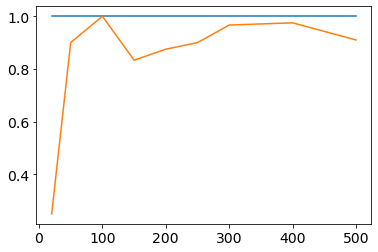

In [222]:
plt.plot(Nlist, train_acc, label='train')
plt.plot(Nlist, val_acc, label='valid')
plt.plot(Nlist, std_, label='std')
plt.legend()
plt.show()

In [157]:
"""#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores"""

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25it/s]


### Feature importance

In [199]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

In [200]:
minval=0.005
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

------------- Feature importance sum = 1.0
------------- Showing feature with importance > 0.005
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.13350166
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.10268991
3 value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.0884196
4 value__fft_coefficient__attr_"imag"__coeff_2 0.03344077
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.026566762
6 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 0.023949858
7 value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.020189742
8 value__longest_strike_below_mean 0.016635824
9 value__fft_coefficient__attr_"angle"__coeff_6 0.015977522
10 value__fourier_entropy__bins_5 0.015830213
11 value__fft_coefficient__attr_"real"__coeff_1 0.015035977
12 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.014608494
13 value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0 0.012857